In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from models.lenet_300_100 import Real, Quat, std_hparams

std_hparams = std_hparams()

batch_size = std_hparams['training']['batch_size']
num_epochs = std_hparams['training']['num_epochs']
learning_rate = std_hparams['training']['learning_rate']

c:\Users\amukh\OneDrive\Desktop\CS460_project\quartLT23\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cpu')

data = torch.tensor(pd.read_csv("../data/mnist/train.csv", header=None).values)
x, y = (data[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(data[:, 0].long(), 10).to(device)

# test = torch.tensor(pd.read_csv("../data/mnist/test.csv", header=None).values)
# x_test, y_test = (test[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(test[:, 0].long(), 10).to(device)

In [3]:
def train(model, optimiser, x, y, num_epochs=num_epochs, batch_size=batch_size):
    accuracies = []
    losses = []

    for epoch in tqdm(range(num_epochs)):
        for i in range(0, len(x), batch_size):
            batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
            optimiser.zero_grad()
            output = model(batch_x)
            loss = F.mse_loss(output, batch_y)
            loss.backward()
            optimiser.step()

        y_pred = torch.cat([model(c).detach().cpu() for c in torch.chunk(x, 4)])
        accuracies.append(accuracy_score(y.cpu().argmax(1), y_pred.argmax(1))*100)
        
        losses.append(loss.item())
        
    return accuracies, losses

In [4]:
model = Real()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy_real, loss_real = train(model, optimiser, x, y)

100%|██████████| 80/80 [13:43<00:00, 10.30s/it]


In [5]:
model = Quat()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracy_quat, loss_quat = train(model, optimiser, x, y)

100%|██████████| 80/80 [15:47<00:00, 11.84s/it]


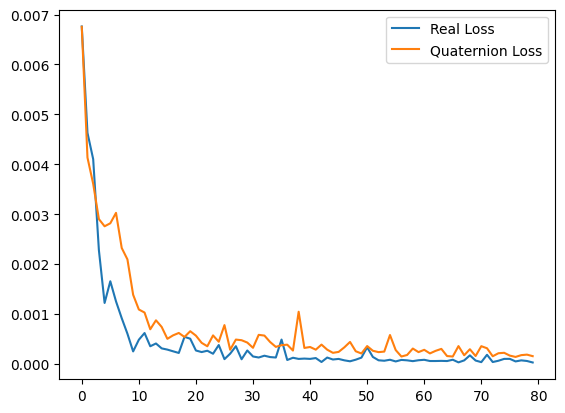

In [6]:
plt.plot(np.arange(len(loss_real)), loss_real, label='Real Loss')
plt.plot(np.arange(len(loss_quat)), loss_quat, label='Quaternion Loss')
plt.legend()

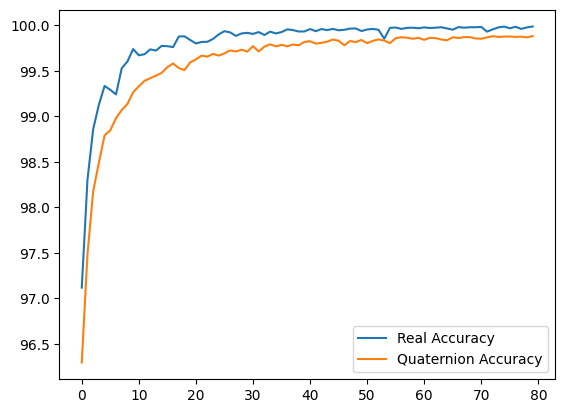

In [7]:
plt.plot(np.arange(len(accuracy_real)), accuracy_real, label='Real Accuracy')
plt.plot(np.arange(len(accuracy_quat)), accuracy_quat, label='Quaternion Accuracy')
plt.legend()